In [10]:
import re
import os
import pathlib
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results").resolve()

# Directory for tidied data (output directory)
data_dir = (pathlib.Path(project_dir) / "data").resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()



# Experiment constants
exp_name = "02_http_constant_throughput"
file_prefix = "exp-02"

In [11]:

"""Load cleaned/aggregated data sets

resource_df -> CPU/Mem utilization for experiments
fortio_df -> Load test results from fortio
"""

resource_df = pd.read_feather(data_dir / "resource_results.feather")
fortio_df = pd.read_feather(data_dir / "fortio_results.feather")

In [12]:
"""
Prepares the experiment data

"""


exp = fortio_df[fortio_df["experiment"] == exp_name]
exp = exp.drop("actual_qps", 1)
exp = exp.explode("latency")
exp = exp.reset_index(drop=True)
exp = exp.astype({
    "latency": np.float64
})

exp = exp.sort_values("mesh", ascending=True)


exp.head()

,experiment,mesh,requested_qps,protocol,payload,latency
6601700,02_http_constant_throughput,Baseline,100,http,0,107.426867
4953938,02_http_constant_throughput,Baseline,1000,http,0,0.136927
4953939,02_http_constant_throughput,Baseline,1000,http,0,0.148402
4953940,02_http_constant_throughput,Baseline,1000,http,0,0.182864
4953941,02_http_constant_throughput,Baseline,1000,http,0,0.177764


In [13]:
quantiles = [
    0.99,
    0.999,
    0.9999
]
data = exp.groupby(["mesh", "requested_qps"])["latency"].quantile(quantiles)
data

mesh      requested_qps        
Baseline  1              0.9900      3.273676
                         0.9990     74.046968
                         0.9999     99.073680
          100            0.9900      1.453152
                         0.9990     48.874224
                         0.9999     90.842767
          1000           0.9900      1.981052
                         0.9990     25.886985
                         0.9999    100.317322
          500            0.9900      2.125728
                         0.9990     53.927783
                         0.9999     93.882280
Cilium    1              0.9900      5.281064
                         0.9990     43.702760
                         0.9999     87.369395
          100            0.9900      2.251530
                         0.9990     47.936992
                         0.9999    135.060809
          1000           0.9900      2.579821
                         0.9990     20.667022
                         0.9999    111.655514
  

In [14]:
d = data.unstack().reset_index()

In [15]:
m = d.melt(id_vars=["mesh", "requested_qps"], value_vars=[0.99, 0.999, 0.9999], var_name="quantile")
m

,mesh,requested_qps,quantile,value
0,Baseline,1,0.99,3.273676
1,Baseline,100,0.99,1.453152
2,Baseline,1000,0.99,1.981052
3,Baseline,500,0.99,2.125728
4,Cilium,1,0.99,5.281064
5,Cilium,100,0.99,2.251530
6,Cilium,1000,0.99,2.579821
7,Cilium,500,0.99,2.337985
8,Istio,1,0.99,6.579215
9,Istio,100,0.99,2.907973


<AxesSubplot:xlabel='mesh', ylabel='value'>

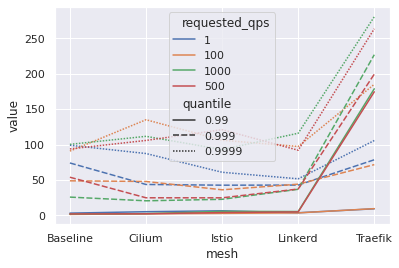

In [16]:
sns.lineplot(data=m, x="mesh", y="value", hue="requested_qps", style="quantile" )

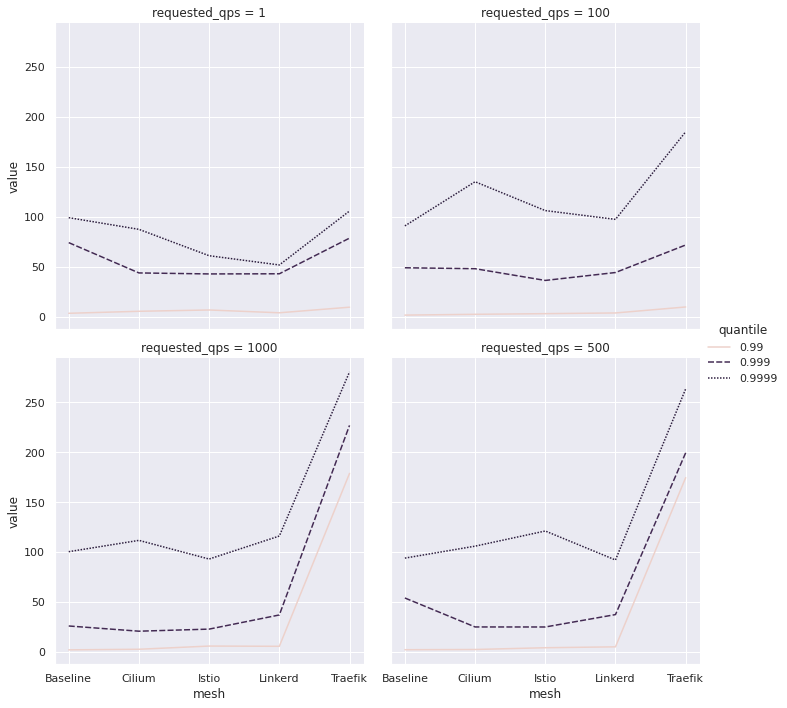

In [33]:
g = sns.relplot(data=m, x="mesh", y="value", col="requested_qps", hue="quantile", style="quantile", col_wrap=2, kind="line")
g

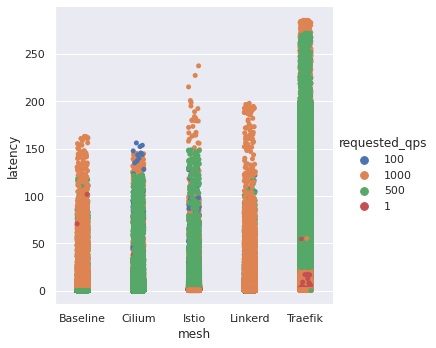

In [24]:
sns.catplot(data=exp, x="mesh", y="latency", hue="requested_qps")

In [34]:
sns.displot(data=exp, x="latency", col="mesh")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fe1ec0ef700> (for post_execute):


KeyboardInterrupt: 